In [1]:
import sage
from sklearn.model_selection import train_test_split


# Load data
df = sage.datasets.credit()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]
categorical_inds = [feature_names.index(col) for col in categorical_columns]

# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [2]:
import os

from catboost import CatBoostClassifier


model_filename = "../credit_model.cbm"

if os.path.isfile(model_filename):
    model = CatBoostClassifier()
    model.load_model(model_filename)
else:
    model = CatBoostClassifier(iterations=50, learning_rate=0.3, depth=3)
    model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val), verbose=False)
    model.save_model(model_filename)

In [3]:
import numpy as np
from sklearn.metrics import log_loss


# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test.astype(int), p[np.newaxis].repeat(len(test), 0))
ce = log_loss(Y_test.astype(int), model.predict_proba(test))

print('Base rate cross entropy = {:.3f}'.format(base_ce))
print('Model cross entropy = {:.3f}'.format(ce))

Base rate cross entropy = 0.602
Model cross entropy = 0.457


In [4]:
from sklearn.metrics import roc_auc_score

print("ROC AUC Score = {:.3f}".format(roc_auc_score(Y_test, model.predict_proba(test)[:, 1])))

ROC AUC Score = 0.849


In [5]:
from sklearn.metrics import confusion_matrix

pred_test = model.predict_proba(test)
pred_test = np.argmax(pred_test, axis=1)

tn, fp, fn, tp = confusion_matrix(Y_test, pred_test, labels=[0,1]).ravel()
n = tn + fp
fpr = fp / n if n > 0.0 else np.float64(0.0)

print("False positive rate = {:.3f}".format(fpr))

False positive rate = 0.552


In [16]:
print("Classifier got {} negative examples wrong".format(int(round(Y_test.sum() * fpr))))

Classifier got 39 negative examples wrong


# Global FPR

In [7]:
# Setup and calculate with custom fairness-related loss function
imputer = sage.MarginalImputer(model, train[:512])
estimator_fpr = sage.PermutationEstimator(imputer, 'fpr')
%time sage_values_fpr = estimator_fpr(test, Y_test, verbose=True, thresh=0.2)

# Print results
print("SAGE values using false positive rate as loss:", sage_values_fpr)

  0%|          | 0/1 [00:00<?, ?it/s]

tn = 0, fp = 156, fn = 0, tp = 356
===> Iteration 0, Prev loss = 1.0 [outer loop]
tn = 0, fp = 156, fn = 0, tp = 356
	Loss = 1.0 [inner loop]
tn = 0, fp = 156, fn = 0, tp = 356
	Loss = 1.0 [inner loop]
tn = 2, fp = 154, fn = 1, tp = 355
	Loss = 0.9871794871794872 [inner loop]
tn = 6, fp = 150, fn = 1, tp = 355
	Loss = 0.9615384615384616 [inner loop]
tn = 10, fp = 146, fn = 2, tp = 354
	Loss = 0.9358974358974359 [inner loop]
tn = 9, fp = 147, fn = 3, tp = 353
	Loss = 0.9423076923076923 [inner loop]
tn = 7, fp = 149, fn = 5, tp = 351
	Loss = 0.9551282051282052 [inner loop]
tn = 8, fp = 148, fn = 4, tp = 352
	Loss = 0.9487179487179487 [inner loop]
tn = 11, fp = 145, fn = 4, tp = 352
	Loss = 0.9294871794871795 [inner loop]
tn = 15, fp = 141, fn = 3, tp = 353
	Loss = 0.9038461538461539 [inner loop]
tn = 18, fp = 138, fn = 5, tp = 351
	Loss = 0.8846153846153846 [inner loop]
tn = 22, fp = 134, fn = 6, tp = 350
	Loss = 0.8589743589743589 [inner loop]
tn = 26, fp = 130, fn = 5, tp = 351
	Loss =

tn = 1, fp = 136, fn = 0, tp = 375
	Loss = 0.9927007299270073 [inner loop]
tn = 1, fp = 136, fn = 0, tp = 375
	Loss = 0.9927007299270073 [inner loop]
tn = 2, fp = 135, fn = 0, tp = 375
	Loss = 0.9854014598540146 [inner loop]
tn = 2, fp = 135, fn = 0, tp = 375
	Loss = 0.9854014598540146 [inner loop]
tn = 5, fp = 132, fn = 0, tp = 375
	Loss = 0.9635036496350365 [inner loop]
tn = 6, fp = 131, fn = 3, tp = 372
	Loss = 0.9562043795620438 [inner loop]
tn = 12, fp = 125, fn = 5, tp = 370
	Loss = 0.9124087591240876 [inner loop]
tn = 14, fp = 123, fn = 6, tp = 369
	Loss = 0.8978102189781022 [inner loop]
tn = 16, fp = 121, fn = 8, tp = 367
	Loss = 0.8832116788321168 [inner loop]
tn = 22, fp = 115, fn = 9, tp = 366
	Loss = 0.8394160583941606 [inner loop]
tn = 27, fp = 110, fn = 9, tp = 366
	Loss = 0.8029197080291971 [inner loop]
tn = 26, fp = 111, fn = 12, tp = 363
	Loss = 0.8102189781021898 [inner loop]
tn = 30, fp = 107, fn = 14, tp = 361
	Loss = 0.781021897810219 [inner loop]
tn = 39, fp = 98,

tn = 0, fp = 148, fn = 0, tp = 364
===> Iteration 13, Prev loss = 1.0 [outer loop]
tn = 0, fp = 148, fn = 0, tp = 364
	Loss = 1.0 [inner loop]
tn = 0, fp = 148, fn = 0, tp = 364
	Loss = 1.0 [inner loop]
tn = 2, fp = 146, fn = 0, tp = 364
	Loss = 0.9864864864864865 [inner loop]
tn = 2, fp = 146, fn = 0, tp = 364
	Loss = 0.9864864864864865 [inner loop]
tn = 4, fp = 144, fn = 0, tp = 364
	Loss = 0.972972972972973 [inner loop]
tn = 8, fp = 140, fn = 2, tp = 362
	Loss = 0.9459459459459459 [inner loop]
tn = 6, fp = 142, fn = 3, tp = 361
	Loss = 0.9594594594594594 [inner loop]
tn = 9, fp = 139, fn = 4, tp = 360
	Loss = 0.9391891891891891 [inner loop]
tn = 16, fp = 132, fn = 3, tp = 361
	Loss = 0.8918918918918919 [inner loop]
tn = 23, fp = 125, fn = 4, tp = 360
	Loss = 0.8445945945945946 [inner loop]
tn = 27, fp = 121, fn = 9, tp = 355
	Loss = 0.8175675675675675 [inner loop]
tn = 29, fp = 119, fn = 12, tp = 352
	Loss = 0.8040540540540541 [inner loop]
tn = 30, fp = 118, fn = 12, tp = 352
	Loss 

tn = 3, fp = 137, fn = 1, tp = 371
	Loss = 0.9785714285714285 [inner loop]
tn = 6, fp = 134, fn = 1, tp = 371
	Loss = 0.9571428571428572 [inner loop]
tn = 9, fp = 131, fn = 1, tp = 371
	Loss = 0.9357142857142857 [inner loop]
tn = 10, fp = 130, fn = 1, tp = 371
	Loss = 0.9285714285714286 [inner loop]
tn = 11, fp = 129, fn = 2, tp = 370
	Loss = 0.9214285714285714 [inner loop]
tn = 16, fp = 124, fn = 3, tp = 369
	Loss = 0.8857142857142857 [inner loop]
tn = 19, fp = 121, fn = 3, tp = 369
	Loss = 0.8642857142857143 [inner loop]
tn = 22, fp = 118, fn = 6, tp = 366
	Loss = 0.8428571428571429 [inner loop]
tn = 29, fp = 111, fn = 8, tp = 364
	Loss = 0.7928571428571428 [inner loop]
tn = 30, fp = 110, fn = 9, tp = 363
	Loss = 0.7857142857142857 [inner loop]
tn = 29, fp = 111, fn = 10, tp = 362
	Loss = 0.7928571428571428 [inner loop]
tn = 39, fp = 101, fn = 10, tp = 362
	Loss = 0.7214285714285714 [inner loop]
tn = 46, fp = 94, fn = 10, tp = 362
	Loss = 0.6714285714285714 [inner loop]
tn = 51, fp =

tn = 12, fp = 140, fn = 1, tp = 359
	Loss = 0.9210526315789473 [inner loop]
tn = 15, fp = 137, fn = 2, tp = 358
	Loss = 0.9013157894736842 [inner loop]
tn = 18, fp = 134, fn = 4, tp = 356
	Loss = 0.881578947368421 [inner loop]
tn = 20, fp = 132, fn = 4, tp = 356
	Loss = 0.868421052631579 [inner loop]
tn = 25, fp = 127, fn = 6, tp = 354
	Loss = 0.8355263157894737 [inner loop]
tn = 28, fp = 124, fn = 8, tp = 352
	Loss = 0.8157894736842105 [inner loop]
tn = 30, fp = 122, fn = 10, tp = 350
	Loss = 0.8026315789473685 [inner loop]
tn = 34, fp = 118, fn = 7, tp = 353
	Loss = 0.7763157894736842 [inner loop]
tn = 37, fp = 115, fn = 10, tp = 350
	Loss = 0.756578947368421 [inner loop]
tn = 47, fp = 105, fn = 11, tp = 349
	Loss = 0.6907894736842105 [inner loop]
tn = 52, fp = 100, fn = 10, tp = 350
	Loss = 0.6578947368421053 [inner loop]
tn = 52, fp = 100, fn = 14, tp = 346
	Loss = 0.6578947368421053 [inner loop]
tn = 57, fp = 95, fn = 15, tp = 345
	Loss = 0.625 [inner loop]
tn = 65, fp = 87, fn = 

tn = 22, fp = 127, fn = 7, tp = 356
	Loss = 0.8523489932885906 [inner loop]
tn = 26, fp = 123, fn = 6, tp = 357
	Loss = 0.825503355704698 [inner loop]
tn = 28, fp = 121, fn = 7, tp = 356
	Loss = 0.8120805369127517 [inner loop]
tn = 27, fp = 122, fn = 6, tp = 357
	Loss = 0.8187919463087249 [inner loop]
tn = 27, fp = 122, fn = 9, tp = 354
	Loss = 0.8187919463087249 [inner loop]
tn = 33, fp = 116, fn = 11, tp = 352
	Loss = 0.7785234899328859 [inner loop]
tn = 39, fp = 110, fn = 12, tp = 351
	Loss = 0.738255033557047 [inner loop]
tn = 40, fp = 109, fn = 12, tp = 351
	Loss = 0.7315436241610739 [inner loop]
tn = 44, fp = 105, fn = 14, tp = 349
	Loss = 0.7046979865771812 [inner loop]
tn = 49, fp = 100, fn = 13, tp = 350
	Loss = 0.6711409395973155 [inner loop]
tn = 58, fp = 91, fn = 11, tp = 352
	Loss = 0.610738255033557 [inner loop]
StdDev Ratio = 0.2751 (Converge at 0.2000)
tn = 0, fp = 137, fn = 0, tp = 375
===> Iteration 29, Prev loss = 1.0 [outer loop]
tn = 0, fp = 137, fn = 0, tp = 375
	

tn = 35, fp = 96, fn = 14, tp = 367
	Loss = 0.732824427480916 [inner loop]
tn = 46, fp = 85, fn = 14, tp = 367
	Loss = 0.648854961832061 [inner loop]
tn = 49, fp = 82, fn = 17, tp = 364
	Loss = 0.6259541984732825 [inner loop]
tn = 50, fp = 81, fn = 17, tp = 364
	Loss = 0.6183206106870229 [inner loop]
tn = 55, fp = 76, fn = 17, tp = 364
	Loss = 0.5801526717557252 [inner loop]
tn = 58, fp = 73, fn = 20, tp = 361
	Loss = 0.5572519083969466 [inner loop]
tn = 62, fp = 69, fn = 18, tp = 363
	Loss = 0.5267175572519084 [inner loop]
tn = 71, fp = 60, fn = 18, tp = 363
	Loss = 0.4580152671755725 [inner loop]
StdDev Ratio = 0.2679 (Converge at 0.2000)
tn = 0, fp = 159, fn = 0, tp = 353
===> Iteration 34, Prev loss = 1.0 [outer loop]
tn = 0, fp = 159, fn = 0, tp = 353
	Loss = 1.0 [inner loop]
tn = 2, fp = 157, fn = 0, tp = 353
	Loss = 0.9874213836477987 [inner loop]
tn = 2, fp = 157, fn = 0, tp = 353
	Loss = 0.9874213836477987 [inner loop]
tn = 5, fp = 154, fn = 0, tp = 353
	Loss = 0.9685534591194

tn = 49, fp = 87, fn = 14, tp = 362
	Loss = 0.6397058823529411 [inner loop]
tn = 51, fp = 85, fn = 14, tp = 362
	Loss = 0.625 [inner loop]
tn = 54, fp = 82, fn = 16, tp = 360
	Loss = 0.6029411764705882 [inner loop]
tn = 59, fp = 77, fn = 14, tp = 362
	Loss = 0.5661764705882353 [inner loop]
tn = 60, fp = 76, fn = 14, tp = 362
	Loss = 0.5588235294117647 [inner loop]
StdDev Ratio = 0.3099 (Converge at 0.2000)
tn = 0, fp = 139, fn = 0, tp = 373
===> Iteration 39, Prev loss = 1.0 [outer loop]
tn = 0, fp = 139, fn = 0, tp = 373
	Loss = 1.0 [inner loop]
tn = 0, fp = 139, fn = 0, tp = 373
	Loss = 1.0 [inner loop]
tn = 1, fp = 138, fn = 0, tp = 373
	Loss = 0.9928057553956835 [inner loop]
tn = 1, fp = 138, fn = 0, tp = 373
	Loss = 0.9928057553956835 [inner loop]
tn = 3, fp = 136, fn = 2, tp = 371
	Loss = 0.9784172661870504 [inner loop]
tn = 8, fp = 131, fn = 4, tp = 369
	Loss = 0.9424460431654677 [inner loop]
tn = 11, fp = 128, fn = 4, tp = 369
	Loss = 0.920863309352518 [inner loop]
tn = 10, fp 

tn = 63, fp = 87, fn = 18, tp = 344
	Loss = 0.58 [inner loop]
tn = 67, fp = 83, fn = 16, tp = 346
	Loss = 0.5533333333333333 [inner loop]
StdDev Ratio = 0.2639 (Converge at 0.2000)
tn = 0, fp = 152, fn = 0, tp = 360
===> Iteration 44, Prev loss = 1.0 [outer loop]
tn = 0, fp = 152, fn = 0, tp = 360
	Loss = 1.0 [inner loop]
tn = 3, fp = 149, fn = 0, tp = 360
	Loss = 0.9802631578947368 [inner loop]
tn = 6, fp = 146, fn = 0, tp = 360
	Loss = 0.9605263157894737 [inner loop]
tn = 8, fp = 144, fn = 1, tp = 359
	Loss = 0.9473684210526315 [inner loop]
tn = 11, fp = 141, fn = 3, tp = 357
	Loss = 0.9276315789473685 [inner loop]
tn = 11, fp = 141, fn = 3, tp = 357
	Loss = 0.9276315789473685 [inner loop]
tn = 11, fp = 141, fn = 4, tp = 356
	Loss = 0.9276315789473685 [inner loop]
tn = 13, fp = 139, fn = 4, tp = 356
	Loss = 0.9144736842105263 [inner loop]
tn = 17, fp = 135, fn = 5, tp = 355
	Loss = 0.8881578947368421 [inner loop]
tn = 19, fp = 133, fn = 4, tp = 356
	Loss = 0.875 [inner loop]
tn = 27,

tn = 0, fp = 155, fn = 0, tp = 357
===> Iteration 49, Prev loss = 1.0 [outer loop]
tn = 0, fp = 155, fn = 0, tp = 357
	Loss = 1.0 [inner loop]
tn = 1, fp = 154, fn = 0, tp = 357
	Loss = 0.9935483870967742 [inner loop]
tn = 3, fp = 152, fn = 0, tp = 357
	Loss = 0.9806451612903225 [inner loop]
tn = 4, fp = 151, fn = 0, tp = 357
	Loss = 0.9741935483870968 [inner loop]
tn = 8, fp = 147, fn = 1, tp = 356
	Loss = 0.9483870967741935 [inner loop]
tn = 12, fp = 143, fn = 1, tp = 356
	Loss = 0.9225806451612903 [inner loop]
tn = 16, fp = 139, fn = 3, tp = 354
	Loss = 0.896774193548387 [inner loop]
tn = 17, fp = 138, fn = 4, tp = 353
	Loss = 0.8903225806451613 [inner loop]
tn = 20, fp = 135, fn = 6, tp = 351
	Loss = 0.8709677419354839 [inner loop]
tn = 26, fp = 129, fn = 6, tp = 351
	Loss = 0.832258064516129 [inner loop]
tn = 25, fp = 130, fn = 8, tp = 349
	Loss = 0.8387096774193549 [inner loop]
tn = 29, fp = 126, fn = 9, tp = 348
	Loss = 0.8129032258064516 [inner loop]
tn = 36, fp = 119, fn = 9, 

tn = 0, fp = 151, fn = 0, tp = 361
	Loss = 1.0 [inner loop]
tn = 3, fp = 148, fn = 1, tp = 360
	Loss = 0.9801324503311258 [inner loop]
tn = 3, fp = 148, fn = 1, tp = 360
	Loss = 0.9801324503311258 [inner loop]
tn = 6, fp = 145, fn = 1, tp = 360
	Loss = 0.9602649006622517 [inner loop]
tn = 9, fp = 142, fn = 1, tp = 360
	Loss = 0.9403973509933775 [inner loop]
tn = 10, fp = 141, fn = 1, tp = 360
	Loss = 0.9337748344370861 [inner loop]
tn = 15, fp = 136, fn = 2, tp = 359
	Loss = 0.9006622516556292 [inner loop]
tn = 19, fp = 132, fn = 4, tp = 357
	Loss = 0.8741721854304636 [inner loop]
tn = 20, fp = 131, fn = 8, tp = 353
	Loss = 0.8675496688741722 [inner loop]
tn = 25, fp = 126, fn = 8, tp = 353
	Loss = 0.8344370860927153 [inner loop]
tn = 29, fp = 122, fn = 10, tp = 351
	Loss = 0.8079470198675497 [inner loop]
tn = 32, fp = 119, fn = 11, tp = 350
	Loss = 0.7880794701986755 [inner loop]
tn = 39, fp = 112, fn = 11, tp = 350
	Loss = 0.7417218543046358 [inner loop]
tn = 45, fp = 106, fn = 12, t

tn = 2, fp = 147, fn = 1, tp = 362
	Loss = 0.9865771812080537 [inner loop]
tn = 6, fp = 143, fn = 2, tp = 361
	Loss = 0.959731543624161 [inner loop]
tn = 7, fp = 142, fn = 3, tp = 360
	Loss = 0.9530201342281879 [inner loop]
tn = 13, fp = 136, fn = 2, tp = 361
	Loss = 0.912751677852349 [inner loop]
tn = 14, fp = 135, fn = 2, tp = 361
	Loss = 0.9060402684563759 [inner loop]
tn = 15, fp = 134, fn = 6, tp = 357
	Loss = 0.8993288590604027 [inner loop]
tn = 19, fp = 130, fn = 6, tp = 357
	Loss = 0.87248322147651 [inner loop]
tn = 22, fp = 127, fn = 6, tp = 357
	Loss = 0.8523489932885906 [inner loop]
tn = 24, fp = 125, fn = 9, tp = 354
	Loss = 0.8389261744966443 [inner loop]
tn = 31, fp = 118, fn = 9, tp = 354
	Loss = 0.7919463087248322 [inner loop]
tn = 35, fp = 114, fn = 14, tp = 349
	Loss = 0.7651006711409396 [inner loop]
tn = 42, fp = 107, fn = 16, tp = 347
	Loss = 0.7181208053691275 [inner loop]
tn = 48, fp = 101, fn = 17, tp = 346
	Loss = 0.6778523489932886 [inner loop]
tn = 48, fp = 10

tn = 10, fp = 137, fn = 3, tp = 362
	Loss = 0.9319727891156463 [inner loop]
tn = 15, fp = 132, fn = 3, tp = 362
	Loss = 0.8979591836734694 [inner loop]
tn = 19, fp = 128, fn = 6, tp = 359
	Loss = 0.8707482993197279 [inner loop]
tn = 24, fp = 123, fn = 5, tp = 360
	Loss = 0.8367346938775511 [inner loop]
tn = 24, fp = 123, fn = 5, tp = 360
	Loss = 0.8367346938775511 [inner loop]
tn = 23, fp = 124, fn = 4, tp = 361
	Loss = 0.8435374149659864 [inner loop]
tn = 27, fp = 120, fn = 6, tp = 359
	Loss = 0.8163265306122449 [inner loop]
tn = 33, fp = 114, fn = 11, tp = 354
	Loss = 0.7755102040816326 [inner loop]
tn = 40, fp = 107, fn = 11, tp = 354
	Loss = 0.7278911564625851 [inner loop]
tn = 45, fp = 102, fn = 13, tp = 352
	Loss = 0.6938775510204082 [inner loop]
tn = 49, fp = 98, fn = 16, tp = 349
	Loss = 0.6666666666666666 [inner loop]
tn = 59, fp = 88, fn = 16, tp = 349
	Loss = 0.5986394557823129 [inner loop]
tn = 68, fp = 79, fn = 15, tp = 350
	Loss = 0.5374149659863946 [inner loop]
tn = 77, 

tn = 18, fp = 107, fn = 9, tp = 378
	Loss = 0.856 [inner loop]
tn = 22, fp = 103, fn = 9, tp = 378
	Loss = 0.824 [inner loop]
tn = 25, fp = 100, fn = 9, tp = 378
	Loss = 0.8 [inner loop]
tn = 27, fp = 98, fn = 11, tp = 376
	Loss = 0.784 [inner loop]
tn = 33, fp = 92, fn = 13, tp = 374
	Loss = 0.736 [inner loop]
tn = 39, fp = 86, fn = 14, tp = 373
	Loss = 0.688 [inner loop]
tn = 46, fp = 79, fn = 16, tp = 371
	Loss = 0.632 [inner loop]
tn = 51, fp = 74, fn = 14, tp = 373
	Loss = 0.592 [inner loop]
tn = 58, fp = 67, fn = 17, tp = 370
	Loss = 0.536 [inner loop]
tn = 62, fp = 63, fn = 21, tp = 366
	Loss = 0.504 [inner loop]
StdDev Ratio = 0.2109 (Converge at 0.2000)
tn = 0, fp = 139, fn = 0, tp = 373
===> Iteration 70, Prev loss = 1.0 [outer loop]
tn = 0, fp = 139, fn = 0, tp = 373
	Loss = 1.0 [inner loop]
tn = 1, fp = 138, fn = 0, tp = 373
	Loss = 0.9928057553956835 [inner loop]
tn = 1, fp = 138, fn = 0, tp = 373
	Loss = 0.9928057553956835 [inner loop]
tn = 1, fp = 138, fn = 0, tp = 373
	

tn = 40, fp = 100, fn = 13, tp = 359
	Loss = 0.7142857142857143 [inner loop]
tn = 48, fp = 92, fn = 16, tp = 356
	Loss = 0.6571428571428571 [inner loop]
tn = 62, fp = 78, fn = 15, tp = 357
	Loss = 0.5571428571428572 [inner loop]
tn = 67, fp = 73, fn = 15, tp = 357
	Loss = 0.5214285714285715 [inner loop]
tn = 74, fp = 66, fn = 15, tp = 357
	Loss = 0.4714285714285714 [inner loop]
StdDev Ratio = 0.2164 (Converge at 0.2000)
tn = 0, fp = 163, fn = 0, tp = 349
===> Iteration 75, Prev loss = 1.0 [outer loop]
tn = 0, fp = 163, fn = 0, tp = 349
	Loss = 1.0 [inner loop]
tn = 1, fp = 162, fn = 0, tp = 349
	Loss = 0.9938650306748467 [inner loop]
tn = 2, fp = 161, fn = 0, tp = 349
	Loss = 0.9877300613496932 [inner loop]
tn = 4, fp = 159, fn = 1, tp = 348
	Loss = 0.9754601226993865 [inner loop]
tn = 5, fp = 158, fn = 1, tp = 348
	Loss = 0.9693251533742331 [inner loop]
tn = 10, fp = 153, fn = 2, tp = 347
	Loss = 0.9386503067484663 [inner loop]
tn = 17, fp = 146, fn = 1, tp = 348
	Loss = 0.89570552147

tn = 49, fp = 86, fn = 18, tp = 359
	Loss = 0.6370370370370371 [inner loop]
tn = 59, fp = 76, fn = 19, tp = 358
	Loss = 0.562962962962963 [inner loop]
StdDev Ratio = 0.2010 (Converge at 0.2000)
tn = 0, fp = 145, fn = 0, tp = 367
===> Iteration 80, Prev loss = 1.0 [outer loop]
tn = 0, fp = 145, fn = 0, tp = 367
	Loss = 1.0 [inner loop]
tn = 0, fp = 145, fn = 1, tp = 366
	Loss = 1.0 [inner loop]
tn = 2, fp = 143, fn = 2, tp = 365
	Loss = 0.9862068965517241 [inner loop]
tn = 2, fp = 143, fn = 1, tp = 366
	Loss = 0.9862068965517241 [inner loop]
tn = 5, fp = 140, fn = 3, tp = 364
	Loss = 0.9655172413793104 [inner loop]
tn = 6, fp = 139, fn = 3, tp = 364
	Loss = 0.9586206896551724 [inner loop]
tn = 7, fp = 138, fn = 4, tp = 363
	Loss = 0.9517241379310345 [inner loop]
tn = 10, fp = 135, fn = 5, tp = 362
	Loss = 0.9310344827586207 [inner loop]
tn = 13, fp = 132, fn = 4, tp = 363
	Loss = 0.9103448275862069 [inner loop]
tn = 14, fp = 131, fn = 5, tp = 362
	Loss = 0.903448275862069 [inner loop]
t

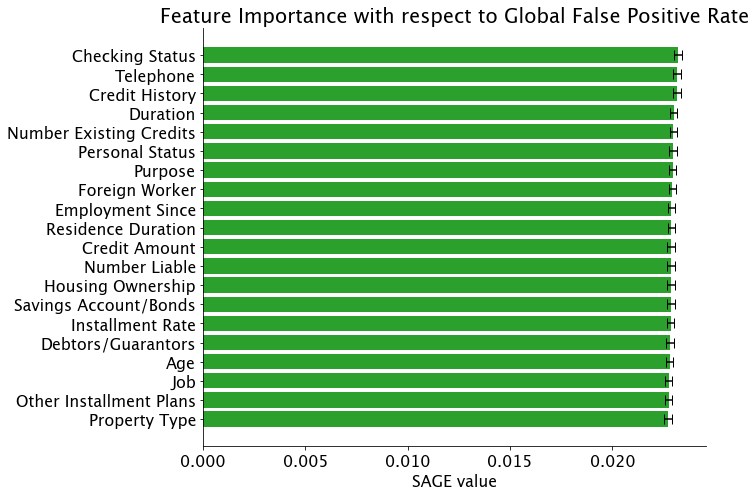

In [8]:
sage_values_fpr.plot(feature_names, title='Feature Importance with respect to Global False Positive Rate')

# Young group FPR

In [9]:
age_col = feature_names.index("Age")

In [10]:
where_young_train = train[:,age_col] <= 30
where_young_test = test[:,age_col] <= 30

test_young = test[where_young_test]
Y_test_young = Y_test[where_young_test]

In [11]:
# Setup and calculate with custom fairness-related loss function
imputer_young = sage.MarginalImputer(model, train[where_young_train])
estimator_young_fpr = sage.PermutationEstimator(imputer_young, 'fpr')
%time sage_values_young_fpr = estimator_young_fpr(test_young, Y_test_young, verbose=True, thresh=0.2)

# Print results
print("SAGE values using false positive rate as loss:", sage_values_young_fpr)

  0%|          | 0/1 [00:00<?, ?it/s]

tn = 0, fp = 219, fn = 0, tp = 293
===> Iteration 0, Prev loss = 1.0 [outer loop]
tn = 0, fp = 219, fn = 0, tp = 293
	Loss = 1.0 [inner loop]
tn = 1, fp = 218, fn = 0, tp = 293
	Loss = 0.9954337899543378 [inner loop]
tn = 3, fp = 216, fn = 1, tp = 292
	Loss = 0.9863013698630136 [inner loop]
tn = 7, fp = 212, fn = 1, tp = 292
	Loss = 0.9680365296803652 [inner loop]
tn = 10, fp = 209, fn = 1, tp = 292
	Loss = 0.954337899543379 [inner loop]
tn = 18, fp = 201, fn = 1, tp = 292
	Loss = 0.9178082191780822 [inner loop]
tn = 20, fp = 199, fn = 1, tp = 292
	Loss = 0.908675799086758 [inner loop]
tn = 25, fp = 194, fn = 2, tp = 291
	Loss = 0.8858447488584474 [inner loop]
tn = 30, fp = 189, fn = 1, tp = 292
	Loss = 0.863013698630137 [inner loop]
tn = 30, fp = 189, fn = 1, tp = 292
	Loss = 0.863013698630137 [inner loop]
tn = 36, fp = 183, fn = 2, tp = 291
	Loss = 0.8356164383561644 [inner loop]
tn = 44, fp = 175, fn = 3, tp = 290
	Loss = 0.7990867579908676 [inner loop]
tn = 50, fp = 169, fn = 2, tp

tn = 6, fp = 211, fn = 1, tp = 294
	Loss = 0.9723502304147466 [inner loop]
tn = 12, fp = 205, fn = 1, tp = 294
	Loss = 0.9447004608294931 [inner loop]
tn = 14, fp = 203, fn = 1, tp = 294
	Loss = 0.9354838709677419 [inner loop]
tn = 15, fp = 202, fn = 1, tp = 294
	Loss = 0.9308755760368663 [inner loop]
tn = 20, fp = 197, fn = 1, tp = 294
	Loss = 0.9078341013824884 [inner loop]
tn = 23, fp = 194, fn = 4, tp = 291
	Loss = 0.8940092165898618 [inner loop]
tn = 26, fp = 191, fn = 4, tp = 291
	Loss = 0.880184331797235 [inner loop]
tn = 36, fp = 181, fn = 7, tp = 288
	Loss = 0.8341013824884793 [inner loop]
tn = 44, fp = 173, fn = 5, tp = 290
	Loss = 0.7972350230414746 [inner loop]
tn = 46, fp = 171, fn = 4, tp = 291
	Loss = 0.7880184331797235 [inner loop]
tn = 60, fp = 157, fn = 4, tp = 291
	Loss = 0.7235023041474654 [inner loop]
tn = 68, fp = 149, fn = 3, tp = 292
	Loss = 0.6866359447004609 [inner loop]
tn = 76, fp = 141, fn = 3, tp = 292
	Loss = 0.6497695852534562 [inner loop]
tn = 86, fp = 

tn = 9, fp = 223, fn = 0, tp = 280
	Loss = 0.9612068965517241 [inner loop]
tn = 13, fp = 219, fn = 0, tp = 280
	Loss = 0.9439655172413793 [inner loop]
tn = 18, fp = 214, fn = 1, tp = 279
	Loss = 0.9224137931034483 [inner loop]
tn = 20, fp = 212, fn = 1, tp = 279
	Loss = 0.9137931034482759 [inner loop]
tn = 26, fp = 206, fn = 0, tp = 280
	Loss = 0.8879310344827587 [inner loop]
tn = 31, fp = 201, fn = 1, tp = 279
	Loss = 0.8663793103448276 [inner loop]
tn = 37, fp = 195, fn = 2, tp = 278
	Loss = 0.8405172413793104 [inner loop]
tn = 35, fp = 197, fn = 3, tp = 277
	Loss = 0.8491379310344828 [inner loop]
tn = 43, fp = 189, fn = 1, tp = 279
	Loss = 0.8146551724137931 [inner loop]
tn = 53, fp = 179, fn = 1, tp = 279
	Loss = 0.771551724137931 [inner loop]
tn = 66, fp = 166, fn = 1, tp = 279
	Loss = 0.7155172413793104 [inner loop]
tn = 71, fp = 161, fn = 2, tp = 278
	Loss = 0.6939655172413793 [inner loop]
tn = 90, fp = 142, fn = 1, tp = 279
	Loss = 0.6120689655172413 [inner loop]
tn = 106, fp =

tn = 17, fp = 200, fn = 1, tp = 294
	Loss = 0.9216589861751152 [inner loop]
tn = 22, fp = 195, fn = 2, tp = 293
	Loss = 0.8986175115207373 [inner loop]
tn = 25, fp = 192, fn = 4, tp = 291
	Loss = 0.8847926267281107 [inner loop]
tn = 31, fp = 186, fn = 3, tp = 292
	Loss = 0.8571428571428571 [inner loop]
tn = 34, fp = 183, fn = 3, tp = 292
	Loss = 0.8433179723502304 [inner loop]
tn = 44, fp = 173, fn = 3, tp = 292
	Loss = 0.7972350230414746 [inner loop]
tn = 51, fp = 166, fn = 4, tp = 291
	Loss = 0.7649769585253456 [inner loop]
tn = 55, fp = 162, fn = 3, tp = 292
	Loss = 0.7465437788018433 [inner loop]
tn = 65, fp = 152, fn = 3, tp = 292
	Loss = 0.7004608294930875 [inner loop]
tn = 74, fp = 143, fn = 2, tp = 293
	Loss = 0.6589861751152074 [inner loop]
tn = 91, fp = 126, fn = 1, tp = 294
	Loss = 0.5806451612903226 [inner loop]
tn = 104, fp = 113, fn = 0, tp = 295
	Loss = 0.5207373271889401 [inner loop]
tn = 113, fp = 104, fn = 0, tp = 295
	Loss = 0.4792626728110599 [inner loop]
StdDev Rat

tn = 0, fp = 189, fn = 0, tp = 323
	Loss = 1.0 [inner loop]
tn = 2, fp = 187, fn = 1, tp = 322
	Loss = 0.9894179894179894 [inner loop]
tn = 3, fp = 186, fn = 1, tp = 322
	Loss = 0.9841269841269841 [inner loop]
tn = 5, fp = 184, fn = 2, tp = 321
	Loss = 0.9735449735449735 [inner loop]
tn = 8, fp = 181, fn = 2, tp = 321
	Loss = 0.9576719576719577 [inner loop]
tn = 13, fp = 176, fn = 3, tp = 320
	Loss = 0.9312169312169312 [inner loop]
tn = 15, fp = 174, fn = 4, tp = 319
	Loss = 0.9206349206349206 [inner loop]
tn = 19, fp = 170, fn = 5, tp = 318
	Loss = 0.8994708994708994 [inner loop]
tn = 21, fp = 168, fn = 3, tp = 320
	Loss = 0.8888888888888888 [inner loop]
tn = 25, fp = 164, fn = 3, tp = 320
	Loss = 0.8677248677248677 [inner loop]
tn = 30, fp = 159, fn = 3, tp = 320
	Loss = 0.8412698412698413 [inner loop]
tn = 36, fp = 153, fn = 5, tp = 318
	Loss = 0.8095238095238095 [inner loop]
tn = 42, fp = 147, fn = 3, tp = 320
	Loss = 0.7777777777777778 [inner loop]
tn = 55, fp = 134, fn = 1, tp = 

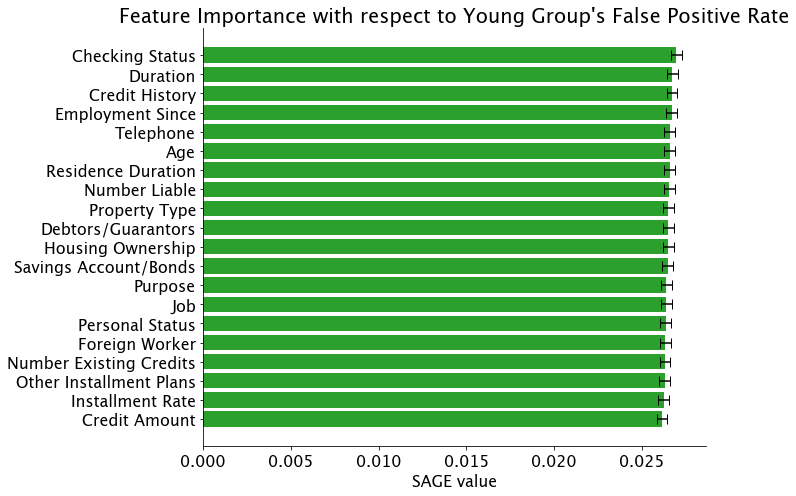

In [12]:
sage_values_young_fpr.plot(feature_names, title='Feature Importance with respect to Young Group\'s False Positive Rate')

# Old group FPR

In [13]:
where_old_train = train[:,age_col] > 30
where_old_test = np.invert(where_young_test)

test_old = test[where_old_test]
Y_test_old = Y_test[where_old_test]

In [14]:
# Setup and calculate with custom fairness-related loss function
imputer_old = sage.MarginalImputer(model, train[where_old_train])
estimator_old_fpr = sage.PermutationEstimator(imputer_old, 'fpr')
%time sage_values_old_fpr = estimator_old_fpr(test_old, Y_test_old, verbose=True, thresh=0.2)

# Print results
print("SAGE values using false positive rate as loss:", sage_values_old_fpr)

tn = 15, fp = 105, fn = 10, tp = 382
	Loss = 0.875 [inner loop]
tn = 16, fp = 104, fn = 11, tp = 381
	Loss = 0.8666666666666667 [inner loop]
tn = 20, fp = 100, fn = 12, tp = 380
	Loss = 0.8333333333333334 [inner loop]
tn = 25, fp = 95, fn = 14, tp = 378
	Loss = 0.7916666666666666 [inner loop]
tn = 32, fp = 88, fn = 16, tp = 376
	Loss = 0.7333333333333333 [inner loop]
tn = 33, fp = 87, fn = 18, tp = 374
	Loss = 0.725 [inner loop]
tn = 39, fp = 81, fn = 20, tp = 372
	Loss = 0.675 [inner loop]
tn = 40, fp = 80, fn = 22, tp = 370
	Loss = 0.6666666666666666 [inner loop]
tn = 41, fp = 79, fn = 28, tp = 364
	Loss = 0.6583333333333333 [inner loop]
tn = 41, fp = 79, fn = 27, tp = 365
	Loss = 0.6583333333333333 [inner loop]
tn = 39, fp = 81, fn = 27, tp = 365
	Loss = 0.675 [inner loop]
tn = 41, fp = 79, fn = 26, tp = 366
	Loss = 0.6583333333333333 [inner loop]
StdDev Ratio = 0.3528 (Converge at 0.2000)
tn = 0, fp = 111, fn = 0, tp = 401
===> Iteration 5, Prev loss = 1.0 [outer loop]
tn = 0, fp =

tn = 23, fp = 82, fn = 13, tp = 394
	Loss = 0.780952380952381 [inner loop]
tn = 27, fp = 78, fn = 17, tp = 390
	Loss = 0.7428571428571429 [inner loop]
tn = 32, fp = 73, fn = 19, tp = 388
	Loss = 0.6952380952380952 [inner loop]
tn = 38, fp = 67, fn = 24, tp = 383
	Loss = 0.638095238095238 [inner loop]
tn = 39, fp = 66, fn = 29, tp = 378
	Loss = 0.6285714285714286 [inner loop]
tn = 42, fp = 63, fn = 30, tp = 377
	Loss = 0.6 [inner loop]
tn = 43, fp = 62, fn = 31, tp = 376
	Loss = 0.5904761904761905 [inner loop]
tn = 41, fp = 64, fn = 26, tp = 381
	Loss = 0.6095238095238096 [inner loop]
StdDev Ratio = 0.2371 (Converge at 0.2000)
tn = 0, fp = 118, fn = 0, tp = 394
===> Iteration 10, Prev loss = 1.0 [outer loop]
tn = 0, fp = 118, fn = 0, tp = 394
	Loss = 1.0 [inner loop]
tn = 0, fp = 118, fn = 1, tp = 393
	Loss = 1.0 [inner loop]
tn = 2, fp = 116, fn = 1, tp = 393
	Loss = 0.9830508474576272 [inner loop]
tn = 3, fp = 115, fn = 2, tp = 392
	Loss = 0.9745762711864406 [inner loop]
tn = 5, fp = 

tn = 32, fp = 72, fn = 27, tp = 381
	Loss = 0.6923076923076923 [inner loop]
tn = 30, fp = 74, fn = 27, tp = 381
	Loss = 0.7115384615384616 [inner loop]
tn = 33, fp = 71, fn = 28, tp = 380
	Loss = 0.6826923076923077 [inner loop]
tn = 34, fp = 70, fn = 29, tp = 379
	Loss = 0.6730769230769231 [inner loop]
tn = 36, fp = 68, fn = 24, tp = 384
	Loss = 0.6538461538461539 [inner loop]
StdDev Ratio = 0.2706 (Converge at 0.2000)
tn = 0, fp = 118, fn = 0, tp = 394
===> Iteration 15, Prev loss = 1.0 [outer loop]
tn = 0, fp = 118, fn = 0, tp = 394
	Loss = 1.0 [inner loop]
tn = 1, fp = 117, fn = 0, tp = 394
	Loss = 0.9915254237288136 [inner loop]
tn = 1, fp = 117, fn = 0, tp = 394
	Loss = 0.9915254237288136 [inner loop]
tn = 1, fp = 117, fn = 1, tp = 393
	Loss = 0.9915254237288136 [inner loop]
tn = 4, fp = 114, fn = 2, tp = 392
	Loss = 0.9661016949152542 [inner loop]
tn = 6, fp = 112, fn = 4, tp = 390
	Loss = 0.9491525423728814 [inner loop]
tn = 8, fp = 110, fn = 6, tp = 388
	Loss = 0.93220338983050

tn = 52, fp = 69, fn = 24, tp = 367
	Loss = 0.5702479338842975 [inner loop]
tn = 52, fp = 69, fn = 23, tp = 368
	Loss = 0.5702479338842975 [inner loop]
StdDev Ratio = 0.2090 (Converge at 0.2000)
tn = 0, fp = 103, fn = 0, tp = 409
===> Iteration 20, Prev loss = 1.0 [outer loop]
tn = 0, fp = 103, fn = 0, tp = 409
	Loss = 1.0 [inner loop]
tn = 0, fp = 103, fn = 0, tp = 409
	Loss = 1.0 [inner loop]
tn = 1, fp = 102, fn = 0, tp = 409
	Loss = 0.9902912621359223 [inner loop]
tn = 2, fp = 101, fn = 0, tp = 409
	Loss = 0.9805825242718447 [inner loop]
tn = 3, fp = 100, fn = 1, tp = 408
	Loss = 0.970873786407767 [inner loop]
tn = 4, fp = 99, fn = 4, tp = 405
	Loss = 0.9611650485436893 [inner loop]
tn = 5, fp = 98, fn = 6, tp = 403
	Loss = 0.9514563106796117 [inner loop]
tn = 8, fp = 95, fn = 7, tp = 402
	Loss = 0.9223300970873787 [inner loop]
tn = 14, fp = 89, fn = 8, tp = 401
	Loss = 0.8640776699029126 [inner loop]
tn = 13, fp = 90, fn = 11, tp = 398
	Loss = 0.8737864077669902 [inner loop]
tn = 

tn = 0, fp = 104, fn = 0, tp = 408
	Loss = 1.0 [inner loop]
tn = 0, fp = 104, fn = 0, tp = 408
	Loss = 1.0 [inner loop]
tn = 1, fp = 103, fn = 0, tp = 408
	Loss = 0.9903846153846154 [inner loop]
tn = 1, fp = 103, fn = 0, tp = 408
	Loss = 0.9903846153846154 [inner loop]
tn = 4, fp = 100, fn = 0, tp = 408
	Loss = 0.9615384615384616 [inner loop]
tn = 6, fp = 98, fn = 2, tp = 406
	Loss = 0.9423076923076923 [inner loop]
tn = 7, fp = 97, fn = 3, tp = 405
	Loss = 0.9326923076923077 [inner loop]
tn = 8, fp = 96, fn = 4, tp = 404
	Loss = 0.9230769230769231 [inner loop]
tn = 13, fp = 91, fn = 3, tp = 405
	Loss = 0.875 [inner loop]
tn = 15, fp = 89, fn = 5, tp = 403
	Loss = 0.8557692307692307 [inner loop]
tn = 19, fp = 85, fn = 8, tp = 400
	Loss = 0.8173076923076923 [inner loop]
tn = 20, fp = 84, fn = 11, tp = 397
	Loss = 0.8076923076923077 [inner loop]
tn = 24, fp = 80, fn = 12, tp = 396
	Loss = 0.7692307692307693 [inner loop]
tn = 29, fp = 75, fn = 15, tp = 393
	Loss = 0.7211538461538461 [inner

tn = 4, fp = 95, fn = 2, tp = 411
	Loss = 0.9595959595959596 [inner loop]
tn = 8, fp = 91, fn = 3, tp = 410
	Loss = 0.9191919191919192 [inner loop]
tn = 12, fp = 87, fn = 5, tp = 408
	Loss = 0.8787878787878788 [inner loop]
tn = 14, fp = 85, fn = 6, tp = 407
	Loss = 0.8585858585858586 [inner loop]
tn = 16, fp = 83, fn = 10, tp = 403
	Loss = 0.8383838383838383 [inner loop]
tn = 16, fp = 83, fn = 13, tp = 400
	Loss = 0.8383838383838383 [inner loop]
tn = 20, fp = 79, fn = 14, tp = 399
	Loss = 0.797979797979798 [inner loop]
tn = 21, fp = 78, fn = 16, tp = 397
	Loss = 0.7878787878787878 [inner loop]
tn = 28, fp = 71, fn = 19, tp = 394
	Loss = 0.7171717171717171 [inner loop]
tn = 31, fp = 68, fn = 22, tp = 391
	Loss = 0.6868686868686869 [inner loop]
tn = 30, fp = 69, fn = 25, tp = 388
	Loss = 0.696969696969697 [inner loop]
tn = 36, fp = 63, fn = 28, tp = 385
	Loss = 0.6363636363636364 [inner loop]
tn = 38, fp = 61, fn = 28, tp = 385
	Loss = 0.6161616161616161 [inner loop]
tn = 36, fp = 63, fn

tn = 12, fp = 113, fn = 7, tp = 380
	Loss = 0.904 [inner loop]
tn = 13, fp = 112, fn = 8, tp = 379
	Loss = 0.896 [inner loop]
tn = 18, fp = 107, fn = 9, tp = 378
	Loss = 0.856 [inner loop]
tn = 20, fp = 105, fn = 12, tp = 375
	Loss = 0.84 [inner loop]
tn = 24, fp = 101, fn = 12, tp = 375
	Loss = 0.808 [inner loop]
tn = 24, fp = 101, fn = 14, tp = 373
	Loss = 0.808 [inner loop]
tn = 31, fp = 94, fn = 13, tp = 374
	Loss = 0.752 [inner loop]
tn = 37, fp = 88, fn = 20, tp = 367
	Loss = 0.704 [inner loop]
tn = 36, fp = 89, fn = 24, tp = 363
	Loss = 0.712 [inner loop]
tn = 40, fp = 85, fn = 23, tp = 364
	Loss = 0.68 [inner loop]
tn = 43, fp = 82, fn = 23, tp = 364
	Loss = 0.656 [inner loop]
tn = 44, fp = 81, fn = 22, tp = 365
	Loss = 0.648 [inner loop]
StdDev Ratio = 0.2697 (Converge at 0.2000)
tn = 0, fp = 127, fn = 0, tp = 385
===> Iteration 36, Prev loss = 1.0 [outer loop]
tn = 0, fp = 127, fn = 0, tp = 385
	Loss = 1.0 [inner loop]
tn = 2, fp = 125, fn = 0, tp = 385
	Loss = 0.984251968503

tn = 39, fp = 93, fn = 19, tp = 361
	Loss = 0.7045454545454546 [inner loop]
tn = 41, fp = 91, fn = 21, tp = 359
	Loss = 0.6893939393939394 [inner loop]
tn = 49, fp = 83, fn = 20, tp = 360
	Loss = 0.6287878787878788 [inner loop]
StdDev Ratio = 0.2480 (Converge at 0.2000)
tn = 0, fp = 103, fn = 0, tp = 409
===> Iteration 45, Prev loss = 1.0 [outer loop]
tn = 0, fp = 103, fn = 0, tp = 409
	Loss = 1.0 [inner loop]
tn = 1, fp = 102, fn = 0, tp = 409
	Loss = 0.9902912621359223 [inner loop]
tn = 1, fp = 102, fn = 0, tp = 409
	Loss = 0.9902912621359223 [inner loop]
tn = 3, fp = 100, fn = 0, tp = 409
	Loss = 0.970873786407767 [inner loop]
tn = 5, fp = 98, fn = 0, tp = 409
	Loss = 0.9514563106796117 [inner loop]
tn = 8, fp = 95, fn = 0, tp = 409
	Loss = 0.9223300970873787 [inner loop]
tn = 12, fp = 91, fn = 2, tp = 407
	Loss = 0.883495145631068 [inner loop]
tn = 13, fp = 90, fn = 3, tp = 406
	Loss = 0.8737864077669902 [inner loop]
tn = 13, fp = 90, fn = 5, tp = 404
	Loss = 0.8737864077669902 [in

tn = 51, fp = 75, fn = 32, tp = 354
	Loss = 0.5952380952380952 [inner loop]
StdDev Ratio = 0.2906 (Converge at 0.2000)
tn = 0, fp = 113, fn = 0, tp = 399
===> Iteration 50, Prev loss = 1.0 [outer loop]
tn = 0, fp = 113, fn = 0, tp = 399
	Loss = 1.0 [inner loop]
tn = 0, fp = 113, fn = 0, tp = 399
	Loss = 1.0 [inner loop]
tn = 1, fp = 112, fn = 0, tp = 399
	Loss = 0.9911504424778761 [inner loop]
tn = 2, fp = 111, fn = 0, tp = 399
	Loss = 0.9823008849557522 [inner loop]
tn = 2, fp = 111, fn = 0, tp = 399
	Loss = 0.9823008849557522 [inner loop]
tn = 4, fp = 109, fn = 2, tp = 397
	Loss = 0.9646017699115044 [inner loop]
tn = 8, fp = 105, fn = 2, tp = 397
	Loss = 0.9292035398230089 [inner loop]
tn = 9, fp = 104, fn = 3, tp = 396
	Loss = 0.9203539823008849 [inner loop]
tn = 12, fp = 101, fn = 5, tp = 394
	Loss = 0.8938053097345132 [inner loop]
tn = 12, fp = 101, fn = 8, tp = 391
	Loss = 0.8938053097345132 [inner loop]
tn = 12, fp = 101, fn = 8, tp = 391
	Loss = 0.8938053097345132 [inner loop]


tn = 26, fp = 83, fn = 12, tp = 391
	Loss = 0.7614678899082569 [inner loop]
tn = 31, fp = 78, fn = 18, tp = 385
	Loss = 0.7155963302752294 [inner loop]
tn = 34, fp = 75, fn = 18, tp = 385
	Loss = 0.6880733944954128 [inner loop]
tn = 36, fp = 73, fn = 18, tp = 385
	Loss = 0.6697247706422018 [inner loop]
tn = 40, fp = 69, fn = 19, tp = 384
	Loss = 0.6330275229357798 [inner loop]
tn = 43, fp = 66, fn = 26, tp = 377
	Loss = 0.6055045871559633 [inner loop]
tn = 41, fp = 68, fn = 23, tp = 380
	Loss = 0.6238532110091743 [inner loop]
StdDev Ratio = 0.2750 (Converge at 0.2000)
tn = 0, fp = 95, fn = 0, tp = 417
===> Iteration 60, Prev loss = 1.0 [outer loop]
tn = 0, fp = 95, fn = 0, tp = 417
	Loss = 1.0 [inner loop]
tn = 2, fp = 93, fn = 0, tp = 417
	Loss = 0.9789473684210527 [inner loop]
tn = 2, fp = 93, fn = 1, tp = 416
	Loss = 0.9789473684210527 [inner loop]
tn = 3, fp = 92, fn = 1, tp = 416
	Loss = 0.968421052631579 [inner loop]
tn = 5, fp = 90, fn = 1, tp = 416
	Loss = 0.9473684210526315 [i

tn = 46, fp = 74, fn = 22, tp = 370
	Loss = 0.6166666666666667 [inner loop]
tn = 52, fp = 68, fn = 21, tp = 371
	Loss = 0.5666666666666667 [inner loop]
StdDev Ratio = 0.2250 (Converge at 0.2000)
tn = 0, fp = 120, fn = 0, tp = 392
===> Iteration 65, Prev loss = 1.0 [outer loop]
tn = 0, fp = 120, fn = 0, tp = 392
	Loss = 1.0 [inner loop]
tn = 1, fp = 119, fn = 0, tp = 392
	Loss = 0.9916666666666667 [inner loop]
tn = 3, fp = 117, fn = 0, tp = 392
	Loss = 0.975 [inner loop]
tn = 3, fp = 117, fn = 0, tp = 392
	Loss = 0.975 [inner loop]
tn = 4, fp = 116, fn = 0, tp = 392
	Loss = 0.9666666666666667 [inner loop]
tn = 5, fp = 115, fn = 0, tp = 392
	Loss = 0.9583333333333334 [inner loop]
tn = 8, fp = 112, fn = 2, tp = 390
	Loss = 0.9333333333333333 [inner loop]
tn = 13, fp = 107, fn = 3, tp = 389
	Loss = 0.8916666666666667 [inner loop]
tn = 17, fp = 103, fn = 4, tp = 388
	Loss = 0.8583333333333333 [inner loop]
tn = 19, fp = 101, fn = 5, tp = 387
	Loss = 0.8416666666666667 [inner loop]
tn = 25, f

tn = 0, fp = 103, fn = 0, tp = 409
	Loss = 1.0 [inner loop]
tn = 0, fp = 103, fn = 0, tp = 409
	Loss = 1.0 [inner loop]
tn = 1, fp = 102, fn = 0, tp = 409
	Loss = 0.9902912621359223 [inner loop]
tn = 2, fp = 101, fn = 3, tp = 406
	Loss = 0.9805825242718447 [inner loop]
tn = 4, fp = 99, fn = 4, tp = 405
	Loss = 0.9611650485436893 [inner loop]
tn = 9, fp = 94, fn = 5, tp = 404
	Loss = 0.912621359223301 [inner loop]
tn = 15, fp = 88, fn = 6, tp = 403
	Loss = 0.8543689320388349 [inner loop]
tn = 18, fp = 85, fn = 12, tp = 397
	Loss = 0.8252427184466019 [inner loop]
tn = 16, fp = 87, fn = 12, tp = 397
	Loss = 0.8446601941747572 [inner loop]
tn = 20, fp = 83, fn = 15, tp = 394
	Loss = 0.8058252427184466 [inner loop]
tn = 21, fp = 82, fn = 13, tp = 396
	Loss = 0.7961165048543689 [inner loop]
tn = 21, fp = 82, fn = 16, tp = 393
	Loss = 0.7961165048543689 [inner loop]
tn = 22, fp = 81, fn = 15, tp = 394
	Loss = 0.7864077669902912 [inner loop]
tn = 27, fp = 76, fn = 17, tp = 392
	Loss = 0.737864

tn = 5, fp = 115, fn = 2, tp = 390
	Loss = 0.9583333333333334 [inner loop]
tn = 5, fp = 115, fn = 2, tp = 390
	Loss = 0.9583333333333334 [inner loop]
tn = 8, fp = 112, fn = 4, tp = 388
	Loss = 0.9333333333333333 [inner loop]
tn = 8, fp = 112, fn = 6, tp = 386
	Loss = 0.9333333333333333 [inner loop]
tn = 11, fp = 109, fn = 8, tp = 384
	Loss = 0.9083333333333333 [inner loop]
tn = 17, fp = 103, fn = 8, tp = 384
	Loss = 0.8583333333333333 [inner loop]
tn = 20, fp = 100, fn = 11, tp = 381
	Loss = 0.8333333333333334 [inner loop]
tn = 21, fp = 99, fn = 11, tp = 381
	Loss = 0.825 [inner loop]
tn = 23, fp = 97, fn = 16, tp = 376
	Loss = 0.8083333333333333 [inner loop]
tn = 27, fp = 93, fn = 17, tp = 375
	Loss = 0.775 [inner loop]
tn = 32, fp = 88, fn = 18, tp = 374
	Loss = 0.7333333333333333 [inner loop]
tn = 36, fp = 84, fn = 18, tp = 374
	Loss = 0.7 [inner loop]
tn = 39, fp = 81, fn = 21, tp = 371
	Loss = 0.675 [inner loop]
tn = 42, fp = 78, fn = 26, tp = 366
	Loss = 0.65 [inner loop]
tn = 45

tn = 16, fp = 104, fn = 9, tp = 383
	Loss = 0.8666666666666667 [inner loop]
tn = 20, fp = 100, fn = 9, tp = 383
	Loss = 0.8333333333333334 [inner loop]
tn = 22, fp = 98, fn = 8, tp = 384
	Loss = 0.8166666666666667 [inner loop]
tn = 27, fp = 93, fn = 11, tp = 381
	Loss = 0.775 [inner loop]
tn = 36, fp = 84, fn = 10, tp = 382
	Loss = 0.7 [inner loop]
tn = 37, fp = 83, fn = 14, tp = 378
	Loss = 0.6916666666666667 [inner loop]
tn = 37, fp = 83, fn = 15, tp = 377
	Loss = 0.6916666666666667 [inner loop]
tn = 38, fp = 82, fn = 16, tp = 376
	Loss = 0.6833333333333333 [inner loop]
tn = 40, fp = 80, fn = 15, tp = 377
	Loss = 0.6666666666666666 [inner loop]
tn = 38, fp = 82, fn = 13, tp = 379
	Loss = 0.6833333333333333 [inner loop]
StdDev Ratio = 0.2356 (Converge at 0.2000)
tn = 0, fp = 112, fn = 0, tp = 400
===> Iteration 81, Prev loss = 1.0 [outer loop]
tn = 0, fp = 112, fn = 0, tp = 400
	Loss = 1.0 [inner loop]
tn = 0, fp = 112, fn = 0, tp = 400
	Loss = 1.0 [inner loop]
tn = 3, fp = 109, fn = 

tn = 22, fp = 71, fn = 19, tp = 400
	Loss = 0.7634408602150538 [inner loop]
tn = 24, fp = 69, fn = 21, tp = 398
	Loss = 0.7419354838709677 [inner loop]
tn = 25, fp = 68, fn = 20, tp = 399
	Loss = 0.7311827956989247 [inner loop]
tn = 28, fp = 65, fn = 22, tp = 397
	Loss = 0.6989247311827957 [inner loop]
tn = 30, fp = 63, fn = 23, tp = 396
	Loss = 0.6774193548387096 [inner loop]
tn = 33, fp = 60, fn = 23, tp = 396
	Loss = 0.6451612903225806 [inner loop]
tn = 36, fp = 57, fn = 25, tp = 394
	Loss = 0.6129032258064516 [inner loop]
StdDev Ratio = 0.2402 (Converge at 0.2000)
tn = 0, fp = 96, fn = 0, tp = 416
===> Iteration 86, Prev loss = 1.0 [outer loop]
tn = 0, fp = 96, fn = 0, tp = 416
	Loss = 1.0 [inner loop]
tn = 0, fp = 96, fn = 0, tp = 416
	Loss = 1.0 [inner loop]
tn = 1, fp = 95, fn = 0, tp = 416
	Loss = 0.9895833333333334 [inner loop]
tn = 1, fp = 95, fn = 4, tp = 412
	Loss = 0.9895833333333334 [inner loop]
tn = 1, fp = 95, fn = 4, tp = 412
	Loss = 0.9895833333333334 [inner loop]
tn 

tn = 35, fp = 69, fn = 20, tp = 388
	Loss = 0.6634615384615384 [inner loop]
tn = 34, fp = 70, fn = 25, tp = 383
	Loss = 0.6730769230769231 [inner loop]
tn = 35, fp = 69, fn = 22, tp = 386
	Loss = 0.6634615384615384 [inner loop]
StdDev Ratio = 0.2298 (Converge at 0.2000)
tn = 0, fp = 124, fn = 0, tp = 388
===> Iteration 91, Prev loss = 1.0 [outer loop]
tn = 0, fp = 124, fn = 0, tp = 388
	Loss = 1.0 [inner loop]
tn = 0, fp = 124, fn = 0, tp = 388
	Loss = 1.0 [inner loop]
tn = 0, fp = 124, fn = 0, tp = 388
	Loss = 1.0 [inner loop]
tn = 1, fp = 123, fn = 0, tp = 388
	Loss = 0.9919354838709677 [inner loop]
tn = 3, fp = 121, fn = 0, tp = 388
	Loss = 0.9758064516129032 [inner loop]
tn = 6, fp = 118, fn = 4, tp = 384
	Loss = 0.9516129032258065 [inner loop]
tn = 11, fp = 113, fn = 4, tp = 384
	Loss = 0.9112903225806451 [inner loop]
tn = 15, fp = 109, fn = 5, tp = 383
	Loss = 0.8790322580645161 [inner loop]
tn = 20, fp = 104, fn = 6, tp = 382
	Loss = 0.8387096774193549 [inner loop]
tn = 23, fp =

tn = 30, fp = 57, fn = 23, tp = 402
	Loss = 0.6551724137931034 [inner loop]
tn = 30, fp = 57, fn = 23, tp = 402
	Loss = 0.6551724137931034 [inner loop]
StdDev Ratio = 0.2322 (Converge at 0.2000)
tn = 0, fp = 123, fn = 0, tp = 389
===> Iteration 100, Prev loss = 1.0 [outer loop]
tn = 0, fp = 123, fn = 0, tp = 389
	Loss = 1.0 [inner loop]
tn = 0, fp = 123, fn = 0, tp = 389
	Loss = 1.0 [inner loop]
tn = 0, fp = 123, fn = 0, tp = 389
	Loss = 1.0 [inner loop]
tn = 1, fp = 122, fn = 0, tp = 389
	Loss = 0.991869918699187 [inner loop]
tn = 4, fp = 119, fn = 1, tp = 388
	Loss = 0.967479674796748 [inner loop]
tn = 7, fp = 116, fn = 3, tp = 386
	Loss = 0.943089430894309 [inner loop]
tn = 6, fp = 117, fn = 7, tp = 382
	Loss = 0.9512195121951219 [inner loop]
tn = 7, fp = 116, fn = 8, tp = 381
	Loss = 0.943089430894309 [inner loop]
tn = 7, fp = 116, fn = 8, tp = 381
	Loss = 0.943089430894309 [inner loop]
tn = 9, fp = 114, fn = 8, tp = 381
	Loss = 0.926829268292683 [inner loop]
tn = 14, fp = 109, fn 

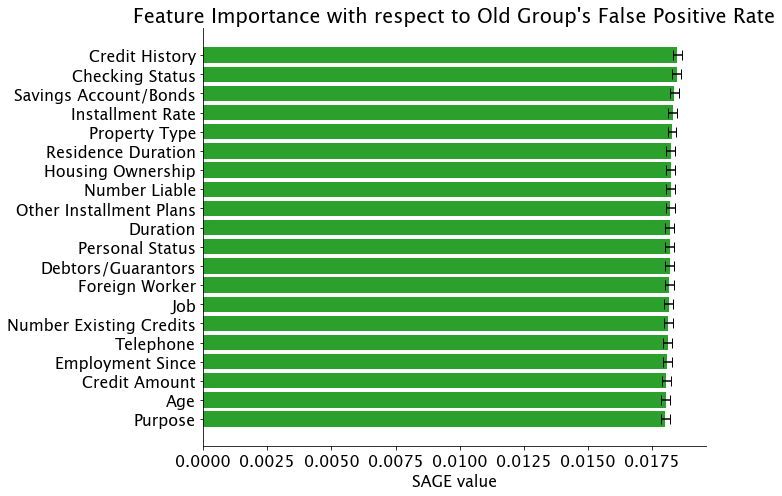

In [ ]:
sage_values_old_fpr.plot(feature_names, title='Feature Importance with respect to Old Group\'s False Positive Rate')